<a href="https://colab.research.google.com/github/aflah02/Easy-Data-Augmentation-Implementation/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import pickle

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def eda_SR(originalSentence, n):
  """
  Paper Methodology -> Randomly choose n words from the sentence that are not stop words. 
                       Replace each of these words with one of its synonyms chosen at random.
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of words to be chosen for random synonym replacement
  """
  stops = set(stopwords.words('english'))
  splitSentence = list(originalSentence.split(" "))
  splitSentenceCopy = splitSentence.copy()
  # Since We Make Changes to The Original Sentence List The Indexes Change and Hence an initial copy proves useful to get values
  ls_nonStopWordIndexes = []
  for i in range(len(splitSentence)):
    if splitSentence[i].lower() not in stops:
      ls_nonStopWordIndexes.append(i)
  if (n > len(ls_nonStopWordIndexes)):
    raise Exception("The number of replacements exceeds the number of non stop word words")
  for i in range(n):
    indexChosen = random.choice(ls_nonStopWordIndexes)
    ls_nonStopWordIndexes.remove(indexChosen)
    synonyms = []
    originalWord = splitSentenceCopy[indexChosen]
    for synset in wordnet.synsets(originalWord):
      for lemma in synset.lemmas():
        if lemma.name() != originalWord:
          synonyms.append(lemma.name())
    if (synonyms == []):
      continue
    splitSentence[indexChosen] = random.choice(synonyms).replace('_', ' ')
  return " ".join(splitSentence)

In [3]:
print(eda_SR("I love to play football", 2))

I love to act as football game


In [4]:
def eda_RI(originalSentence, n):
  """
  Paper Methodology -> Find a random synonym of a random word in the sentence that is not a stop word. 
                       Insert that synonym into a random position in the sentence. Do this n times
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of times the process has to be repeated
  """
  stops = set(stopwords.words('english'))
  splitSentence = list(originalSentence.split(" "))
  splitSentenceCopy = splitSentence.copy() 
  # Since We Make Changes to The Original Sentence List The Indexes Change and Hence an initial copy proves useful to get values
  ls_nonStopWordIndexes = []
  for i in range(len(splitSentence)):
    if splitSentence[i].lower() not in stops:
      ls_nonStopWordIndexes.append(i)
  if (n > len(ls_nonStopWordIndexes)):
    raise Exception("The number of replacements exceeds the number of non stop word words")
  WordCount = len(splitSentence)
  for i in range(n):
    indexChosen = random.choice(ls_nonStopWordIndexes)
    ls_nonStopWordIndexes.remove(indexChosen)
    synonyms = []
    originalWord = splitSentenceCopy[indexChosen]
    for synset in wordnet.synsets(originalWord):
      for lemma in synset.lemmas():
        if lemma.name() != originalWord:
          synonyms.append(lemma.name())
    if (synonyms == []):
      continue
    splitSentence.insert(random.randint(0,WordCount-1), random.choice(synonyms).replace('_', ' '))
  return " ".join(splitSentence)

In [5]:
print(eda_RI("I love to play football", 2))

I love to play toy have intercourse football


In [6]:
def eda_RS(originalSentence, n):
  """
  Paper Methodology -> Find a random synonym of a random word in the sentence that is not a stop word. 
                       Insert that synonym into a random position in the sentence. Do this n times
  originalSentence -> The sentence on which EDA is to be applied
  n -> The number of times the process has to be repeated
  """
  splitSentence = list(originalSentence.split(" "))
  WordCount = len(splitSentence)
  for i in range(n):
    firstIndex = random.randint(0,WordCount-1)
    secondIndex = random.randint(0,WordCount-1)
    while (secondIndex == firstIndex and WordCount != 1):
      secondIndex = random.randint(0,WordCount-1)
    splitSentence[firstIndex], splitSentence[secondIndex] = splitSentence[secondIndex], splitSentence[firstIndex]
  return " ".join(splitSentence)

In [7]:
print(eda_RS("I love to play football", 2))

love to I play football


In [8]:
def eda_RD(originalSentence, p):
  """
  Paper Methodology -> Randomly remove each word in the sentence with probability p.
  originalSentence -> The sentence on which EDA is to be applied
  p -> Probability of a Word Being Removed
  """
  og = originalSentence
  if (p == 1):
      raise Exception("Always an Empty String Will Be Returned") 
  if (p > 1 or p < 0):
    raise Exception("Improper Probability Value")
  splitSentence = list(originalSentence.split(" "))
  lsIndexesRemoved = []
  WordCount = len(splitSentence)
  for i in range(WordCount):
    randomDraw = random.random()
    if randomDraw <= p:
      lsIndexesRemoved.append(i)
  lsRetainingWords = []
  for i in range(len(splitSentence)):
    if i not in lsIndexesRemoved:
      lsRetainingWords.append(splitSentence[i])
  if (lsRetainingWords == []):
    return og
  return " ".join(lsRetainingWords)

In [9]:
print(eda_RD("I love to play football", 0.3))

I love play


### Building Dataset

In [10]:
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv
!wget -q https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/dev.tsv

In [35]:
def buildTrainTestDatasets(doAug, AugTechs, alpha, NumberOfTrainingSamplesTouse, n_aug):
  df_train = pd.read_csv('train.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
  df_dev = pd.read_csv('dev.tsv', delimiter = '\t', names = ['Sentence', 'Label'])
  df_test = pd.read_csv('test.tsv', delimiter = '\t', names = ['Sentence', 'Label'])

  df_train = pd.concat([df_train, df_dev])
  df_train = df_train.reset_index(drop=True)
  df_train = df_train.loc[:, ["Label", "Sentence"]]
  if (NumberOfTrainingSamplesTouse > len(df_train)):
    raise Exception("More Samples Asked For Than Present")

  df_train = df_train.iloc[:NumberOfTrainingSamplesTouse]

  if (doAug):
    if (AugTechs == None):
      AugTechs = ['SR', 'RI', 'RD', 'RS']
    ls_train_labels = df_train['Label'].to_list()
    ls_train_sentences = df_train['Sentence'].to_list()
    count = len(ls_train_sentences)
    for i in range(count):
      for iter in range(n_aug):
        ls_train_labels.append(ls_train_labels[i])
        techniqueChosen = random.choice(AugTechs)
        if (techniqueChosen == 'SR'):
          ls_train_sentences.append(eda_SR(ls_train_sentences[i], int(len(ls_train_sentences[i])*alpha)))
        elif (techniqueChosen == 'RI'):
          ls_train_sentences.append(eda_RI(ls_train_sentences[i], int(len(ls_train_sentences[i])*alpha)))
        elif (techniqueChosen == 'RS'):
          ls_train_sentences.append(eda_RS(ls_train_sentences[i], int(len(ls_train_sentences[i])*alpha)))
        elif (techniqueChosen == 'RD'):
          ls_train_sentences.append(eda_RD(ls_train_sentences[i], alpha))
    df_train = pd.DataFrame(
    {'Label': ls_train_labels,
     'Sentence': ls_train_sentences,
    })
  target_train = df_train.pop('Label')
  target_test = df_test.pop('Label')
  feature_names = ['Sentence']
  train_features = df_train[feature_names]
  test_features = df_test[feature_names]
  train_dataset = tf.convert_to_tensor(train_features)
  test_dataset = tf.convert_to_tensor(test_features)
  return train_dataset, target_train, test_dataset, target_test

In [36]:
train_aug_dataset, target_aug_train, test_aug_dataset, target_aug_test = buildTrainTestDatasets(True, None, 0.05, 500, 16)
train_aug_dataset = tf.squeeze(train_aug_dataset)
test_aug_dataset = tf.squeeze(test_aug_dataset)
target_aug_train = tf.squeeze(target_aug_train)
target_aug_test = tf.squeeze(target_aug_test)

In [37]:
train_nonaug_dataset, target_nonaug_train, test_nonaug_dataset, target_nonaug_test = buildTrainTestDatasets(False, None, None, 500, None)
train_nonaug_dataset = tf.squeeze(train_nonaug_dataset)
test_nonaug_dataset = tf.squeeze(test_nonaug_dataset)
target_nonaug_train = tf.squeeze(target_nonaug_train)
target_nonaug_test = tf.squeeze(target_nonaug_test)

In [38]:
train_aug = tf.data.Dataset.from_tensor_slices((train_aug_dataset, target_aug_train))
train_non_aug = tf.data.Dataset.from_tensor_slices((train_nonaug_dataset, target_nonaug_train))
test_aug = tf.data.Dataset.from_tensor_slices((test_aug_dataset, target_aug_test))
test_non_aug = tf.data.Dataset.from_tensor_slices((test_nonaug_dataset, target_nonaug_test))

In [39]:
for example, label in train_aug.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'
label:  1


In [40]:
for example, label in train_aug.take(10):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'
label:  1
text:  b'apparently reassembled from the cutting room floor of any given daytime soap'
label:  0
text:  b"they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes"
label:  0
text:  b'this is a visually stunning rumination on love , memory , history and the war between art and commerce'
label:  1
text:  b"jonathan parker 's bartleby should have been the be all end all of the modern office anomie films"
label:  1
text:  b'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
label:  1
text:  b'a fan film that for the uninitiated plays better on video with the sound turned down'
label:  0
text:  b'b art and berling are both superb , while huppert is magnificent'
label:

In [41]:
train_aug, train_non_aug, test_aug, test_non_aug

(<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [42]:
for example, label in train_aug.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'
label:  1


In [43]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [44]:
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_aug = test_aug.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_non_aug = train_non_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_non_aug = test_non_aug.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [45]:
train_aug.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [46]:
for example, label in train_aug.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'its a , proves in 101 arthouse though poetic symbolism touch heaven too the be a good of of to sensibilities match two directors'
 b'highly uneven ALT and inconsistent margarita resemble sort of discrepant happy hour kinda resembles the el cheapo margaritas served within'
 b"flick clare peploe 's airless PIE movie adaptation could use a comparable little american pie like irreverence"]

labels:  [1 0 0]


## RNN Model

Paper Uses - 
The architecture used in this paper is as follows: input layer, bi-directional hidden layer with 64 LSTM cells, dropout layer with p=0.5, bi-directional layer of 32 LSTM cells, dropout layer with p=0.5, dense layer of 20 hidden units with ReLU activation, softmax output layer. We initialize this network with random normal weights and train against the categorical crossentropy loss function with the adam optimizer. We use early stopping with a patience of 3 epochs.

Reference for Encoder and some Helper Functions: [Tensorflow Text Classification by RNN Tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn)



In [47]:
VOCAB_SIZE = 5000
encoder_aug = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder_aug.adapt(train_aug.map(lambda text, label: text))

vocab_aug = np.array(encoder_aug.get_vocabulary())

VOCAB_SIZE = 5000
encoder_nonaug = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder_nonaug.adapt(train_non_aug.map(lambda text, label: text))

vocab_nonaug = np.array(encoder_nonaug.get_vocabulary())

In [48]:
encoded_example = encoder_aug(example)[:3].numpy()
encoded_example

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab_aug[encoded_example[n]]))
  print()

Original:  b'its a , proves in 101 arthouse though poetic symbolism touch heaven too the be a good of of to sensibilities match two directors'
Round-trip:  its a proves in 101 arthouse though poetic symbolism touch heaven too the be a good of of to sensibilities match two directors             

Original:  b'highly uneven ALT and inconsistent margarita resemble sort of discrepant happy hour kinda resembles the el cheapo margaritas served within'
Round-trip:  highly uneven alt and inconsistent margarita resemble sort of discrepant happy hour kinda resembles the el cheapo margaritas served within                

Original:  b"flick clare peploe 's airless PIE movie adaptation could use a comparable little american pie like irreverence"
Round-trip:  flick clare peploe s airless pie movie adaptation could use a comparable little american pie like irreverence                   



In [53]:
model_aug = tf.keras.Sequential([
    encoder_aug,
    tf.keras.layers.Embedding(len(encoder_aug.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])
model_aug.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model_nonaug = tf.keras.Sequential([
    encoder_nonaug,
    tf.keras.layers.Embedding(len(encoder_nonaug.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])
model_nonaug.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [54]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history_aug = model_aug.fit(	
      train_aug,
      epochs=50, 
      callbacks=callbacks,
      validation_data=test_aug,
      validation_steps=5
)

history_non_aug = model_nonaug.fit(	
      train_non_aug,
      epochs=50, 
      callbacks=callbacks,
      validation_data=test_non_aug,
      validation_steps=5
)

Epoch 1/50
133/133 [==============================] - 34s 116ms/step - loss: 0.3226 - accuracy: 0.8411 - val_loss: 1.2468 - val_accuracy: 0.6781
Epoch 2/50
133/133 [==============================] - 9s 67ms/step - loss: 0.0150 - accuracy: 0.9974 - val_loss: 1.6593 - val_accuracy: 0.6750
Epoch 3/50
133/133 [==============================] - 9s 68ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 1.9229 - val_accuracy: 0.6781
Epoch 4/50
133/133 [==============================] - 9s 68ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 2.2111 - val_accuracy: 0.6750
Epoch 1/50
8/8 [==============================] - 30s 981ms/step - loss: 0.6932 - accuracy: 0.4760 - val_loss: 0.6931 - val_accuracy: 0.5406
Epoch 2/50
8/8 [==============================] - 1s 83ms/step - loss: 0.6928 - accuracy: 0.5280 - val_loss: 0.6928 - val_accuracy: 0.5281
Epoch 3/50
8/8 [==============================] - 1s 81ms/step - loss: 0.6921 - accuracy: 0.5280 - val_loss: 0.6924 - val_accuracy: 0.5281
Epoch 4

In [55]:
test_aug_loss, test_aug_acc = model_aug.evaluate(test_aug)

print('Test Augmented Loss:', test_aug_loss)
print('Test Augmented Accuracy:', test_aug_acc)

test_non_aug_loss, test_non_aug_acc = model_nonaug.evaluate(test_non_aug)

print('Test Non Augmented Loss:', test_non_aug_loss)
print('Test Non Augmented Accuracy:', test_non_aug_acc)

29/29 [==============================] - 1s 24ms/step - loss: 2.4236 - accuracy: 0.6392
Test Augmented Loss: 2.4235610961914062
Test Augmented Accuracy: 0.6392092108726501
29/29 [==============================] - 1s 24ms/step - loss: 1.4260 - accuracy: 0.6035
Test Non Augmented Loss: 1.4259804487228394
Test Non Augmented Accuracy: 0.603514552116394


(0.0, 2.321572706149891)

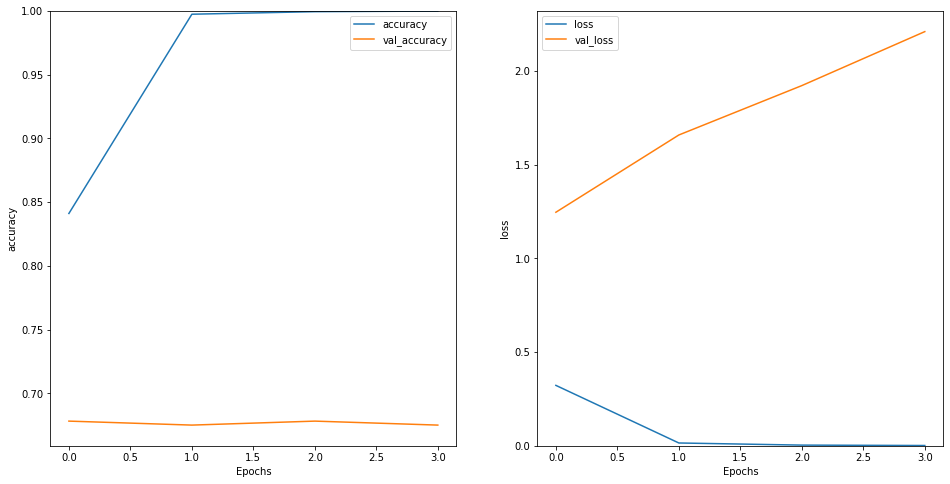

In [56]:
## Augmented Data Training
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_aug, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_aug, 'loss')
plt.ylim(0, None)

(0.0, 1.5156807828694583)

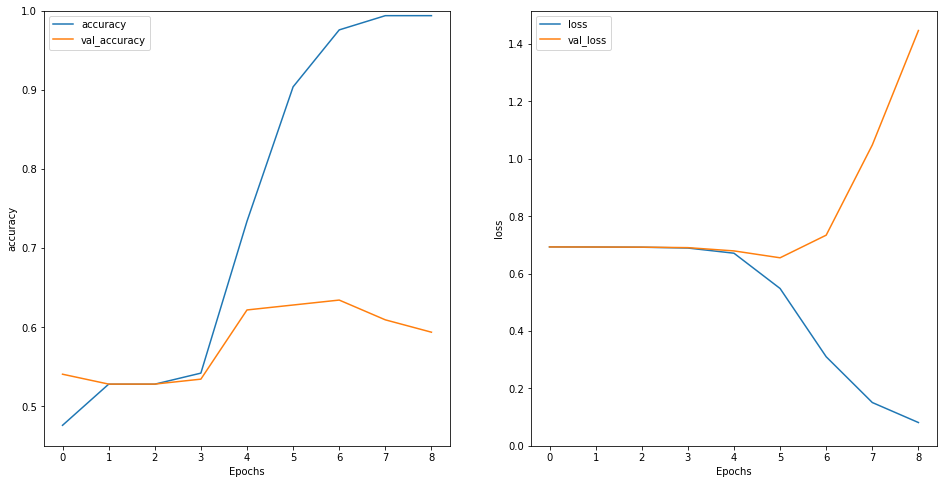

In [57]:
## Non Augmented Data Training
plt.figure(figsize=(16, 8))
plt.title("Non Augmented Data Training")
plt.subplot(1, 2, 1)
plot_graphs(history_non_aug, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_non_aug, 'loss')
plt.ylim(0, None)